# Elevation Covariate

Read elevation data by a bounding box tile for stacking with other covariates in analysis.
Initial version uses SRTM v3 available as Cloud Optimized Geotiffs in MAAP.

In [7]:
#only run this block if needed in a new workspace
%pip install -q rasterio
%pip install -q geopandas
%pip install -q folium

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from maap.maap import MAAP
maap = MAAP()
from pprint import pprint

In [2]:
# generated from this EDSC search: https://ade.maap-project.org:30052/search/granules?p=C1200271393-NASA_MAAP&q=SRTM&tl=1598404169!4!!
collection_info = maap.searchCollection(concept_id="C1200271393-NASA_MAAP", limit=1000)

In [3]:
short_name = collection_info[0]['Collection']['ShortName']
pprint(short_name)

'SRTMGL1_COD'


In [30]:
bbox = '-101.5,45,-100,46'
granule_results = maap.searchGranule(short_name=short_name, bounding_box=bbox , limit=20)

In [31]:
len(granule_results)

9

## Inspect the results


In [9]:
import geopandas as gpd
import folium
import shapely as shp
import folium

In [10]:
def make_polygons(item):
    bounds = item['Granule']['Spatial']['HorizontalSpatialDomain']['Geometry']['BoundingRectangle']
    item_bbox = [float(value) for value in bounds.values()]
    bbox_polygon = shp.geometry.box(
        item_bbox[0], 
        item_bbox[1],
        item_bbox[2], 
        item_bbox[3]
    )
    return bbox_polygon

In [14]:
geometries = gpd.GeoSeries([make_polygons(item) for item in granule_results], crs='EPSG:4326')
geometries

0    POLYGON ((-100.99972 45.00028, -100.99972 43.9...
1    POLYGON ((-98.99972 45.00028, -98.99972 43.999...
2    POLYGON ((-98.99972 47.00028, -98.99972 45.999...
3    POLYGON ((-100.99972 46.00028, -100.99972 44.9...
4    POLYGON ((-100.99972 47.00028, -100.99972 45.9...
5    POLYGON ((-99.99972 45.00028, -99.99972 43.999...
6    POLYGON ((-99.99972 46.00028, -99.99972 44.999...
7    POLYGON ((-98.99972 46.00028, -98.99972 44.999...
8    POLYGON ((-99.99972 47.00028, -99.99972 45.999...
dtype: geometry

In [36]:
bbox_list =  [float(value) for value in bbox.split(',')]
center = shp.geometry.box(*bbox_list).centroid

m = folium.Map(
    location=[center.y,center.x],
    tiles="cartodbpositron",
    zoom_start=7,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}

folium.GeoJson(geometries, name="tiles").add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)
m

## Read the data for the Box

For each result read the subwindow. After reading all the subwindows, merge them together as a single  array. 

Q: is it easier to make a vrt of the files and then request the subwindow, or does that waste time?

In [58]:
import rasterio as rio
from rasterio.merge import merge
from rasterio.session import AWSSession 
from rasterio.plot import show
import boto3

In [56]:
# Set up and aws session
aws_session = AWSSession(boto3.Session())
# Get the s3 urls to the granules
file_s3 = [item['Granule']['OnlineAccessURLs']['OnlineAccessURL']['URL'] for item in granule_results] 
file_s3


['s3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N44W102.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N44W100.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W100.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W102.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W102.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N44W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W100.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W101.SRTMGL1.tif']

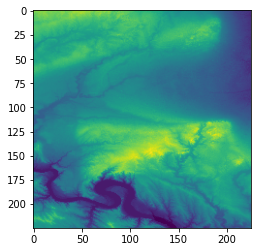

<AxesSubplot:>

In [60]:
# prove that we can read the aws files, an overview should be faster
with rio.Env(aws_session):
    with rio.open(file_s3[1]) as src:
        # List of overviews from biggest to smallest
        oviews = src.overviews(1)

        # Retrieve the smallest thumbnail
        oview = oviews[-1]
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

show(thumbnail)